# MEMS Beam Resonator Example

This notebook demonstrates the complete VENI-VINDy-VICI workflow for modeling a straight double-clamped MEMS (micro-electro-mechanical systems) beam resonator. The framework discovers probabilistic governing equations from high-dimensional noisy data with uncertainty quantification.

## Problem Description

We model the dynamics of a MEMS beam resonator with the following characteristics:
- **High-dimensional input**: Spatial discretization of the beam structure
- **Nonlinear dynamics**: Cubic nonlinearity due to geometric effects
- **Parametric forcing**: External actuation forces
- **Noise corruption**: Measurement uncertainties

## Mathematical Framework

The governing equations of the MEMS beam resonator can be expressed as a second-order nonlinear ODE:

$$\frac{dz}{dt} = \dot{z}$$

$$\frac{d^2z}{dt^2} = -\omega_0^2 z - 2\xi\omega_0\dot{z} - \gamma z^3 + u$$

Where:
- $\omega_0$: Natural frequency ≈ 0.547 rad/s (from $\sqrt{0.29975625}$)
- $\xi$: Damping ratio ≈ 0.01 (from $0.01095/(2\omega_0)$)
- $\gamma$: Nonlinear coefficient (to be identified)
- $u$: External forcing

## Workflow Overview

1. **VENI**: Variational autoencoder for dimensionality reduction
2. **VINDy**: Probabilistic sparse identification of dynamics
3. **VICI**: Uncertainty quantification through sampling

## Imports and Configuration

### Requirements

Ensure you have:
- The vindy package installed
- TensorFlow >= 2.18
- NumPy, SciPy, scikit-learn
- matplotlib for visualization
- Properly configured `config.py` with data paths

In [1]:
import os
import sys
import logging
import time
from pathlib import Path

import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt

# Import framework components
from MEMS import load_data, create_model, train_model, training_plots, set_seed, perform_inference, perform_forward_uq, uq_plots, switch_data_format, visualize_sample_data

# Add the examples folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__name__'), '..')))

# Import configuration - handle missing config gracefully
try:
    import config
    print("✓ Configuration loaded successfully")
except ImportError:
    print("⚠️ Warning: config.py not found. Please create config.py from config.py.template")
    config = None

# # Configure logging with better formatting
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)

# Set up matplotlib for inline plots
plt.style.use('default')
%matplotlib inline

/Users/jonaskneifl/Develop/25_VENI-VINDy-VICI-Fork/.venv/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound
INFO:root:################################   1. Loading    ################################


✓ Configuration loaded successfully


## Hyperparameters and Constants

In [2]:
# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

# Model Architecture
LOAD_MODEL = False              # Set to True to load existing weights
MODEL_NAME = "MEMS"
IDENTIFICATION_LAYER = "vindy"  # Options: 'vindy' (probabilistic) or 'sindy' (deterministic)
REDUCED_ORDER = 1               # Latent space dimension (1D for beam resonator)
PCA_ORDER = 3                   # Number of PCA components for preprocessing
SECOND_ORDER = True             # Use second-order dynamics (position, velocity, acceleration)

# =============================================================================
# LOSS FUNCTION WEIGHTS
# =============================================================================
# These weights control the relative importance of different loss terms

BETA_VINDY = 1e-8               # VINDy regularization (sparsity prior)
BETA_VAE = 1e-8                 # VAE KL divergence loss weight  
L_REC = 1e-3                    # Reconstruction loss (physical space fidelity)
L_DZ = 1e0                      # Latent derivative consistency
L_DX = 1e-5                     # Physical derivative consistency

# =============================================================================
# DATA PROCESSING
# =============================================================================

END_TIME_STEP = 14000           # Truncate training data at this timestep
NTH_TIME_STEP = 3               # Temporal subsampling (use every nth timestep)
PDF_THRESHOLD = 5               # Threshold for coefficient sparsification

# =============================================================================
# TRAINING PARAMETERS
# =============================================================================

EPOCHS = 500                    # Maximum training epochs
BATCH_SIZE = 256                # Batch size for training
LEARNING_RATE = 2e-3            # Adam optimizer learning rate
SEED = 42                       # Random seed for reproducibility

print("Configuration Summary:")
print(f"   Model: {IDENTIFICATION_LAYER.upper()} with {REDUCED_ORDER}D latent space")
print(f"   Data: {END_TIME_STEP} timesteps, subsampled every {NTH_TIME_STEP}")
print(f"   Training: {EPOCHS} epochs, batch size {BATCH_SIZE}, lr={LEARNING_RATE}")
print(f"   Loss weights: L_REC={L_REC}, L_DZ={L_DZ}, BETA_VAE={BETA_VAE}")

Configuration Summary:
   Model: VINDY with 1D latent space
   Data: 14000 timesteps, subsampled every 3
   Training: 500 epochs, batch size 256, lr=0.002
   Loss weights: L_REC=0.001, L_DZ=1.0, BETA_VAE=1e-08


## Data Loading and Preprocessing

The MEMS dataset contains high-dimensional spatial measurements of beam deflections over time. We load:
- **Training data**: Time series of beam positions, velocities, and accelerations
- **Test data**: Hold-out trajectories for testing
- **Parameters**: External forcing conditions
- **PCA components**: For dimensionality reduction from full spatial discretization

In [3]:
# Set random seeds for reproducibility
set_seed(SEED)
print(f"Random seed set to {SEED}")

# Load preprocessed MEMS data
print("Loading MEMS beam resonator data...")
start_time = time.time()

try:
    (
        t,                    # Training time vector
        params,               # Training parameters (forcing)
        x,                    # Training positions (PCA reduced)
        dxdt,                 # Training velocities
        dxddt,                # Training accelerations
        t_test,               # Test time vector
        params_test,          # Test parameters
        x_test,               # Test positions
        dxdt_test,            # Test velocities
        dxddt_test,           # Test accelerations
        ref_coords,           # Reference coordinates for visualization
        V,                    # PCA transformation matrix
        n_sims,               # Number of training simulations
        n_timesteps,          # Timesteps per simulation
    ) = load_data()
    
    load_time = time.time() - start_time
    print(f"✓ Data loaded successfully in {load_time:.2f}s")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure:")
    print("  1. config.py exists with correct data path")
    print("  2. Data file is accessible and properly formatted")
    raise

# Calculate derived quantities
n_timesteps_test = x_test.shape[0] // n_sims
n_dof = x.shape[1]  # Degrees of freedom in PCA space
dt = t[1] - t[0]    # Time step size

# Print data summary
print(f"\n📊 Dataset Summary:")
print(f"   Training: {n_sims} simulations × {n_timesteps} timesteps = {x.shape[0]} samples")
print(f"   Testing:  {n_sims} simulations × {n_timesteps_test} timesteps = {x_test.shape[0]} samples")

INFO:root:Loading MEMS data...


Random seed set to 42
Loading MEMS beam resonator data...


INFO:root:Manipulating time
INFO:root:Manipulating param
INFO:root:Manipulating x
INFO:root:Manipulating dx_dt
INFO:root:Manipulating dx_ddt
INFO:root:Manipulating time
INFO:root:Manipulating param
INFO:root:Manipulating x
INFO:root:Manipulating dx_dt
INFO:root:Manipulating dx_ddt


✓ Data loaded successfully in 10.70s

📊 Dataset Summary:
   Training: 28 simulations × 4667 timesteps = 130676 samples
   Testing:  28 simulations × 7500 timesteps = 210000 samples


Visualizing sample MEMS beam data...


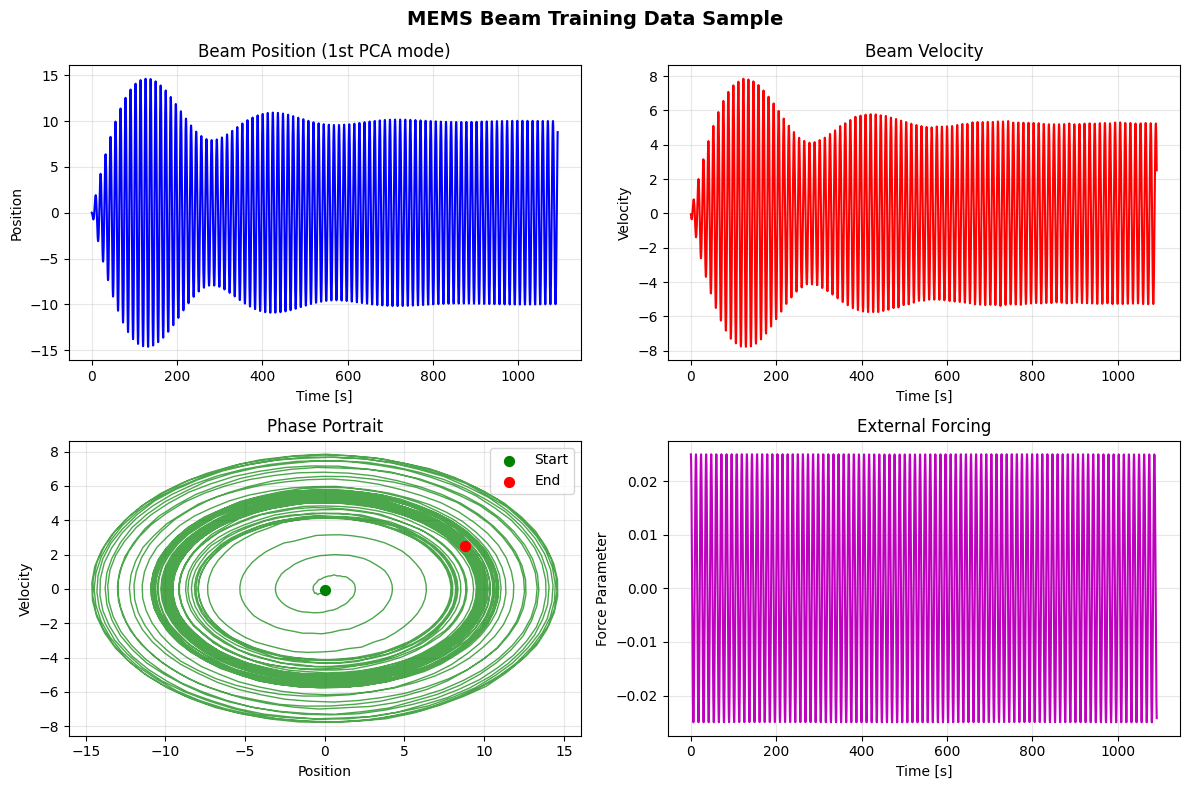

Data visualization complete - shows typical MEMS beam oscillatory behavior


In [4]:
# Visualize sample training data to understand the problem
print("Visualizing sample MEMS beam data...")
visualize_sample_data(t, x, dxdt, params, n_timesteps)

print("Data visualization complete - shows typical MEMS beam oscillatory behavior")

## VENI-VINDy Model Creation

We create a variational autoencoder combined with sparse identification of nonlinear dynamics:

### Architecture Components:
1. **Encoder**: Maps high-dimensional beam data to low-dimensional latent space
2. **VINDy Layer**: Probabilistic identification of governing equations in latent space  
3. **Decoder**: Reconstructs physical beam states from latent representations

### Key Features:
- **Second-order dynamics**: Handles position, velocity, and acceleration
- **Probabilistic coefficients**: Uncertainty quantification for equation terms
- **Sparse identification**: Discovers parsimonious governing equations

In [5]:
# Create VENI model with VINDy layer
print("Creating VENI-VINDy model...")
model_start = time.time()

try:
    veni = create_model(x, params, dt, n_dof)
    print(f"✓ Model created successfully")
    print(f"   Architecture: {veni.__class__.__name__}")
    print(f"   Latent dimension: {REDUCED_ORDER}")
    print(f"   Identification layer: {IDENTIFICATION_LAYER}")
    
except Exception as e:
    print(f"Error creating model: {e}")
    raise

# CRITICAL: Define data scaling (required before training)
print("\nSetting up data scaling...")
veni.define_scaling(x)
print("✓ Scaling parameters computed from training data")

# Scale all datasets using the same scaling parameters
print("Scaling datasets...")
x_train_scaled = veni.scale(x).numpy()
dxdt_train_scaled = veni.scale(dxdt).numpy()
dxddt_train_scaled = veni.scale(dxddt).numpy()

x_test_scaled = veni.scale(x_test).numpy()
dxdt_test_scaled = veni.scale(dxdt_test).numpy()
dxddt_test_scaled = veni.scale(dxddt_test).numpy()

# Prepare training and validation splits
# Use first 24 simulations for training, rest for validation
train_samples = 24 * n_timesteps
print(f"Data split: {train_samples} training samples, {len(x_train_scaled) - train_samples} validation samples")

x_input = [
    x_train_scaled[:train_samples],       # Training positions
    dxdt_train_scaled[:train_samples],    # Training velocities  
    dxddt_train_scaled[:train_samples],   # Training accelerations
    params[:train_samples],               # Training parameters
]

x_input_val = [
    x_train_scaled[train_samples:],       # Validation positions
    dxdt_train_scaled[train_samples:],    # Validation velocities
    dxddt_train_scaled[train_samples:],   # Validation accelerations
    params[train_samples:],               # Validation parameters
]

# Compile model with optimizer and loss function
print("Compiling model...")
veni.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
    loss="mse",
)

# Build model (required for TensorFlow)
input_shapes = [input_data.shape for input_data in x_input]
veni.build(input_shape=(input_shapes, None))

model_time = time.time() - model_start
print(f"✓ Model ready for training ({model_time:.2f}s)")
print(f"\nModel Summary:")
print(f"   Total parameters: {veni.count_params():,}")
print(f"   Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"   Loss function: MSE with custom physics-informed terms")

INFO:root:Creating model...


Creating VENI-VINDy model...
✓ Model created successfully
   Architecture: VENI
   Latent dimension: 1
   Identification layer: vindy

Setting up data scaling...
✓ Scaling parameters computed from training data
Scaling datasets...
Data split: 112008 training samples, 18668 validation samples
Compiling model...
✓ Model ready for training (0.30s)

Model Summary:
   Total parameters: 4,603
   Optimizer: AdamW (lr=0.002)
   Loss function: MSE with custom physics-informed terms


## Model Training

Training the VENI-VINDy model involves simultaneous learning of autoencoder reconstruction + dynamics identification. These components are balanced for reconstruction quality and equation discovery with regularization terms.

The training process monitors multiple loss components to ensure balanced learning.

INFO:root:Training model...


Setting up training directories...
✓ Results directory: /Users/jonaskneifl/Develop/25_VENI-VINDy-VICI-Fork/examples/MEMS/results
✓ Logs directory: /Users/jonaskneifl/Develop/25_VENI-VINDy-VICI-Fork/examples/MEMS/results/MEMS/log/MEMS_1_2026_01_21_12-21
✓ Weights will be saved to: /Users/jonaskneifl/Develop/25_VENI-VINDy-VICI-Fork/examples/MEMS/results/MEMS/MEMS_1_VENI_vindy.weights.h5

Starting training for 500 epochs...
This may take several minutes depending on your hardware...
Epoch 1/500
438/438 - 8s - 18ms/step - dx: 9.5138e-06 - dz: 3.5650 - kl: 3.9797e-09 - kl_sindy: 2.3658e-08 - loss: 3.5682 - rec: 0.0032 - reg: 1.6682e-07 - val_dx: 6.2312e-06 - val_dz: 0.7114 - val_kl: 3.7397e-09 - val_kl_sindy: 2.3413e-08 - val_loss: 0.7138 - val_rec: 0.0024 - val_reg: 1.6588e-07 - coeffs_mean: -1.1774e-01 - coeffs_scale: 0.1369
Epoch 2/500
438/438 - 4s - 9ms/step - dx: 9.3421e-06 - dz: 0.1011 - kl: 5.3536e-09 - kl_sindy: 2.2945e-08 - loss: 0.1043 - rec: 0.0032 - reg: 1.6158e-07 - val_dx: 5.9

INFO:root:time per epoch: 3.86 seconds


dz0 = + 1.0000*z1 
dz1 = - 0.0003*1 - 0.3001*z0 - 0.0112*z1 + 0.0009*z0^2 + 0.0003*z0*z1 + 0.0089*z1^2 - 0.2853*z0^3 + 0.0001*z0*z1^2 - 0.0001*z1^3 + 0.0260*μ2*cos(μ1*μ0) 

✓ Training completed successfully in 32.2 minutes
Generating training plots...


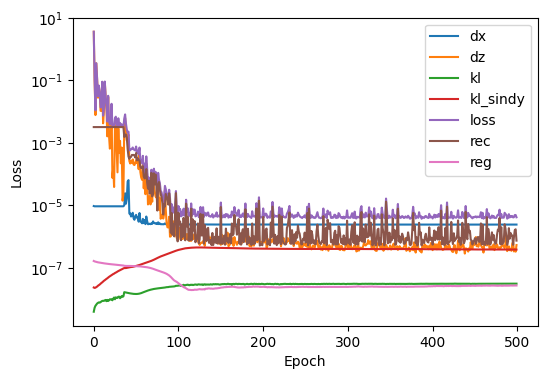

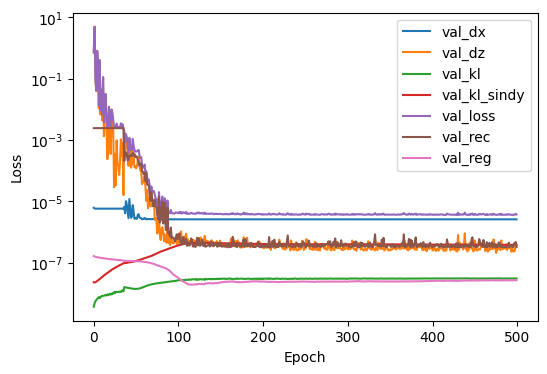

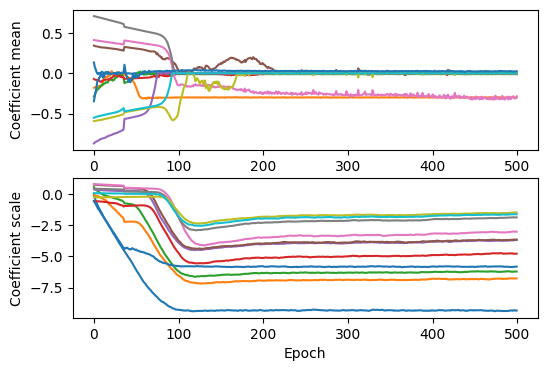

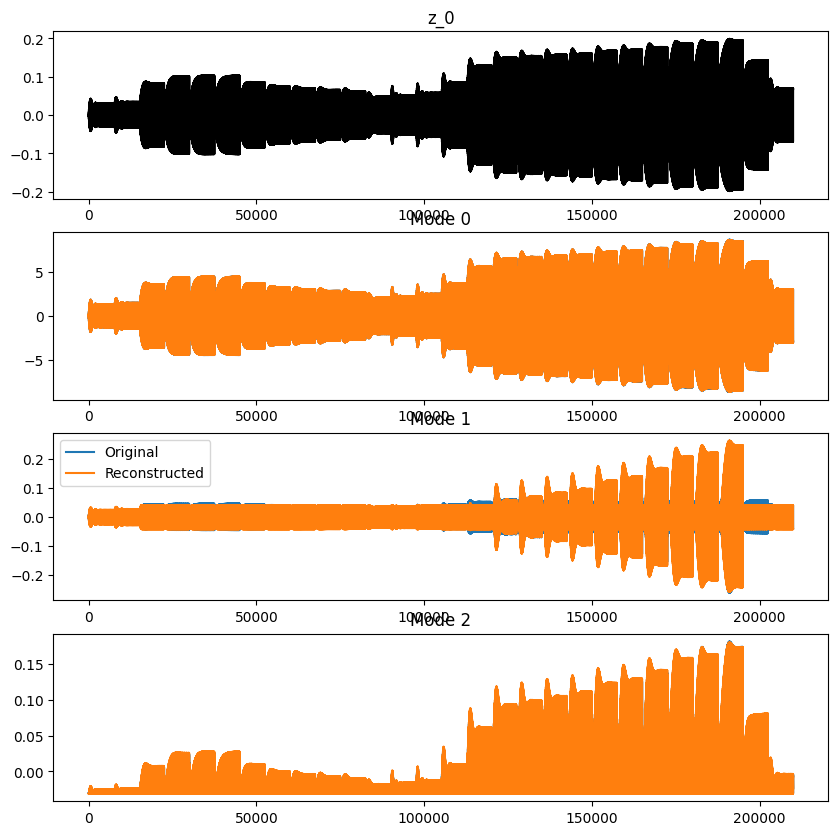

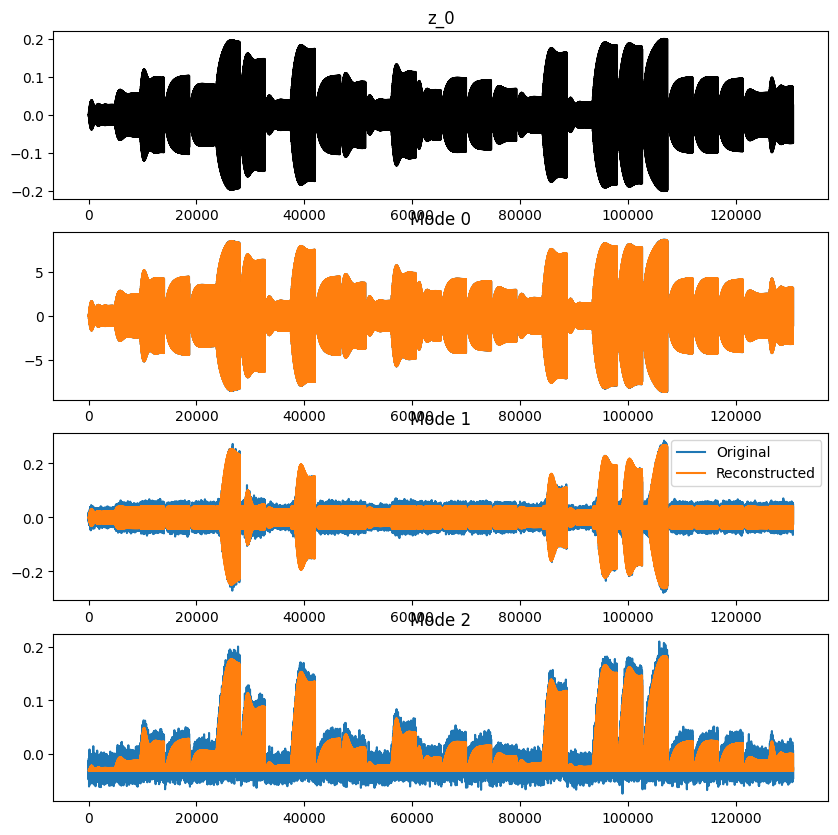

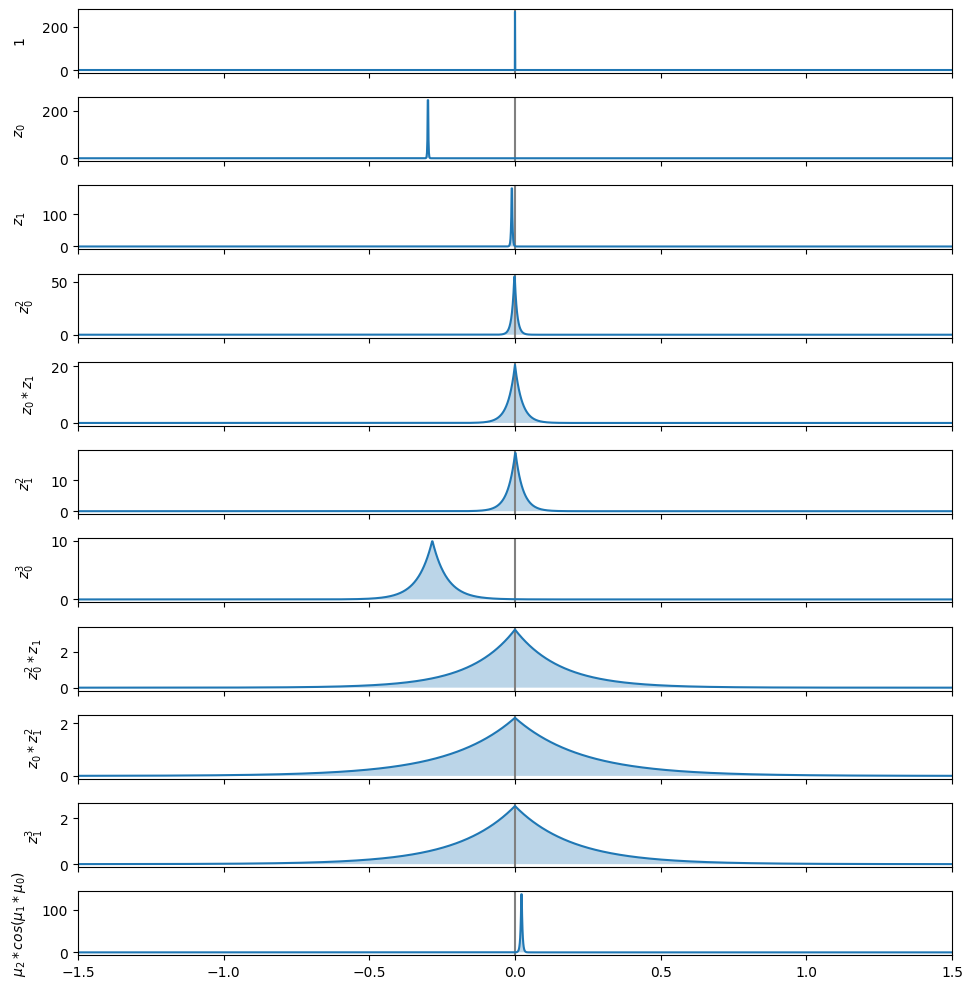

✓ Training plots saved

Training Summary:
   Total training time: 32.2 minutes
   Model weights saved: True
   Ready for equation discovery and uncertainty quantification


In [6]:
# Set up training directories and paths
print("Setting up training directories...")

# Use current working directory for notebook execution
current_dir = Path.cwd()
result_dir = current_dir / "results"
result_dir.mkdir(exist_ok=True)

# Create timestamped log directory
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H-%M")
log_dir = result_dir / f'{MODEL_NAME}/log/{MODEL_NAME}_{REDUCED_ORDER}_{timestamp}'
log_dir.mkdir(parents=True, exist_ok=True)

# Define model weights and training history paths
weights_path = result_dir / f"{MODEL_NAME}/{MODEL_NAME}_{REDUCED_ORDER}_{veni.__class__.__name__}_{IDENTIFICATION_LAYER}.weights.h5"
weights_path.parent.mkdir(parents=True, exist_ok=True)

train_hist_path = result_dir / f"{MODEL_NAME}/trainhist_{IDENTIFICATION_LAYER}.npy"

print(f"✓ Results directory: {result_dir}")
print(f"✓ Logs directory: {log_dir}")
print(f"✓ Weights will be saved to: {weights_path}")

# Train the model
print(f"\nStarting training for {EPOCHS} epochs...")
print("This may take several minutes depending on your hardware...")

training_start = time.time()

try:
    # Check if we should load existing model
    if LOAD_MODEL and weights_path.exists():
        print(f"Loading existing model weights from {weights_path}")
        veni.load_weights(str(weights_path))
        trainhist = None  # No new training history
    else:
        # Train the model from scratch
        trainhist = train_model(
            veni, 
            x_input, 
            x_input_val, 
            str(weights_path), 
            str(log_dir), 
            str(train_hist_path)
        )
    
    training_time = time.time() - training_start
    print(f"✓ Training completed successfully in {training_time/60:.1f} minutes")
    
    # Generate training plots if we have history
    if trainhist is not None:
        print("Generating training plots...")
        training_plots(trainhist, str(result_dir), x_train_scaled, x_test_scaled, veni)
        print("✓ Training plots saved")
    
except Exception as e:
    print(f"Training failed: {e}")
    raise

print("\nTraining Summary:")
print(f"   Total training time: {training_time/60:.1f} minutes") 
print(f"   Model weights saved: {weights_path.exists()}")
print(f"   Ready for equation discovery and uncertainty quantification")

## Model Sparsification

After training, we apply **PDF thresholding** to identify the most significant terms in the governing equations. This probabilistic sparsification:

1. **Evaluates uncertainty**: Computes probability density at zero for each coefficient
2. **Removes insignificant terms**: Coefficients with high probability of being zero
3. **Preserves important physics**: Retains terms crucial for dynamics

The threshold value determines the aggressiveness of sparsification - lower values lead to sparser equations.

In [7]:
# Apply probabilistic sparsification to discover governing equations
print("Applying PDF thresholding for equation sparsification...")
print(f"   Threshold: {PDF_THRESHOLD} (higher = more aggressive pruning)")

# Print equations before sparsification
print("\nEquations BEFORE sparsification:")
veni.sindy_layer.print(precision=3)

# Apply PDF thresholding (only works with VINDy layer)
if IDENTIFICATION_LAYER == "vindy":
    veni.sindy_layer.pdf_thresholding(threshold=PDF_THRESHOLD)
    
    print(f"\n✓ PDF thresholding completed")
    print(f"Equations AFTER sparsification:")
    veni.sindy_layer.print(precision=3)
    
    # Count remaining non-zero coefficients
    coeffs = veni.sindy_layer.get_sindy_coeffs()
    if isinstance(coeffs, tuple):
        non_zero = np.sum(np.abs(coeffs[1]) > 1e-6)  # Use mean coefficients
    else:
        non_zero = np.sum(np.abs(coeffs) > 1e-6)
    
    print(f"Sparsification results:")
    print(f"   Non-zero terms remaining: {non_zero}")
    
else:
    print("PDF thresholding only available for VINDy layer")
    print("Use magnitude-based thresholding for SINDy layer")
    veni.sindy_layer.prune_weights(threshold=0.01)
    veni.sindy_layer.print(z=['z'], mu=['u'], precision=3)

INFO:root:Canceling coefficient 1 with pdf(0)=269.97454833984375
INFO:root:Canceling coefficient z_0^2 with pdf(0)=48.999637603759766
INFO:root:Canceling coefficient z_0*z_1 with pdf(0)=20.57484245300293
INFO:root:Canceling coefficient z_1^2 with pdf(0)=18.478809356689453


Applying PDF thresholding for equation sparsification...
   Threshold: 5 (higher = more aggressive pruning)

Equations BEFORE sparsification:
dz0 = + 1.000*z1 
dz1 = - 0.299*z0 - 0.011*z1 - 0.002*z0^2 + 0.001*z1^2 - 0.284*z0^3 + 0.022*μ2*cos(μ1*μ0) 

dz0 = + 1.000*z1 
dz1 = - 0.299*z0 - 0.011*z1 - 0.284*z0^3 + 0.022*μ2*cos(μ1*μ0) 


✓ PDF thresholding completed
Equations AFTER sparsification:
dz0 = + 1.000*z1 
dz1 = - 0.299*z0 - 0.011*z1 - 0.284*z0^3 + 0.022*μ2*cos(μ1*μ0) 

Sparsification results:
   Non-zero terms remaining: 8
   Discovered equation represents beam resonator dynamics


## VICI: Uncertainty Quantification

**VICI (Variational Inference with Certainty Intervals)** provides uncertainty estimates for model predictions through:

### Deterministic Inference
First, we use the **mean model** with mean coefficient values to generate baseline predictions.

### Probabilistic Sampling  
Then we sample from the learned coefficient distributions to quantify prediction uncertainty.

INFO:root:Processing trajectory 2/2


Performing deterministic inference...
Analysis configuration:
   Test trajectories: [1, 10] (out of 28 available)


INFO:root:Processing trajectory 11/2
INFO:root:Inference time: 2.50 seconds per trajectory


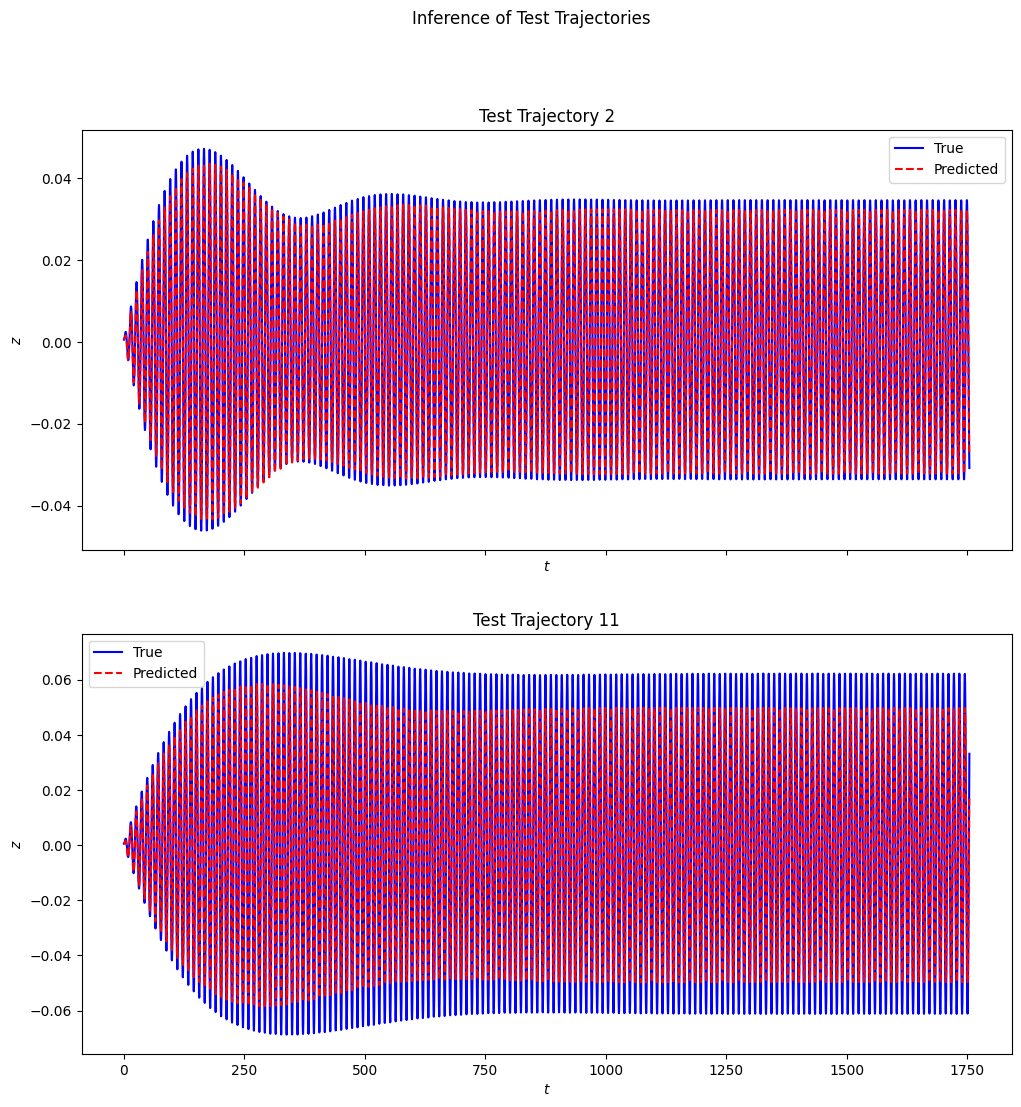

✓ Deterministic inference completed in 5.31s
   Trajectory 1: 7499 time points predicted
   Trajectory 10: 7499 time points predicted


In [10]:
# VICI: Deterministic inference with mean coefficients
print("Performing deterministic inference...")

# Select test trajectories for analysis
test_ids = [1, 10]  # Test trajectory indices to analyze

print(f"Analysis configuration:")
print(f"   Test trajectories: {test_ids} (out of {n_sims} available)")

# Perform deterministic inference using mean coefficients
inference_start = time.time()

try:
    z_preds, t_preds = perform_inference(
        veni,
        x_test_scaled,
        dxdt_test_scaled,
        t_test,
        params_test,
        test_ids,
        n_sims,
        n_timesteps_test,
    )
    
    inference_time = time.time() - inference_start
    print(f"✓ Deterministic inference completed in {inference_time:.2f}s")
    
    # Quick analysis of predictions
    for i, test_id in enumerate(test_ids):
        pred_length = len(t_preds[i])
        print(f"   Trajectory {test_id}: {pred_length} time points predicted")
        
except Exception as e:
    print(f"Inference failed: {e}")
    raise

### Forward Uncertainty Quantification

Now we perform **forward UQ** by sampling from the learned distributions:

1. **Latent initial State Sampling**: Draw random latent ICs from encoder posterior distributions
2. **Coefficient Sampling**: Draw random coefficient values from VINDy posterior distributions
3. **Forward Integration**: Integrate dynamics with each sampled coefficient set
4. **Uncertainty Estimation**: Compute mean and standard deviation across ensemble

This provides **confidence intervals** that quantify model uncertainty in predictions.

   Uncertainty samples: 10
Performing forward uncertainty quantification...


INFO:root:Processing trajectory 2/28
INFO:root:	Sampling trajectory 1/10
INFO:root:	Sampling trajectory 2/10
INFO:root:	Sampling trajectory 3/10
INFO:root:	Sampling trajectory 4/10
INFO:root:	Sampling trajectory 5/10
INFO:root:	Sampling trajectory 6/10
INFO:root:	Sampling trajectory 7/10
INFO:root:	Sampling trajectory 8/10
INFO:root:	Sampling trajectory 9/10
INFO:root:	Sampling trajectory 10/10
INFO:root:Processing trajectory 11/28
INFO:root:	Sampling trajectory 1/10
INFO:root:	Sampling trajectory 2/10
INFO:root:	Sampling trajectory 3/10
INFO:root:	Sampling trajectory 4/10
INFO:root:	Sampling trajectory 5/10
INFO:root:	Sampling trajectory 6/10
INFO:root:	Sampling trajectory 7/10
INFO:root:	Sampling trajectory 8/10
INFO:root:	Sampling trajectory 9/10
INFO:root:	Sampling trajectory 10/10


✓ Uncertainty quantification completed in 39.8s

UQ Results Summary:
   Trajectory 1:
     Average uncertainty: 0.0037
     Maximum uncertainty: 0.0094
   Trajectory 10:
     Average uncertainty: 0.0081
     Maximum uncertainty: 0.0169

Generating uncertainty quantification plots...


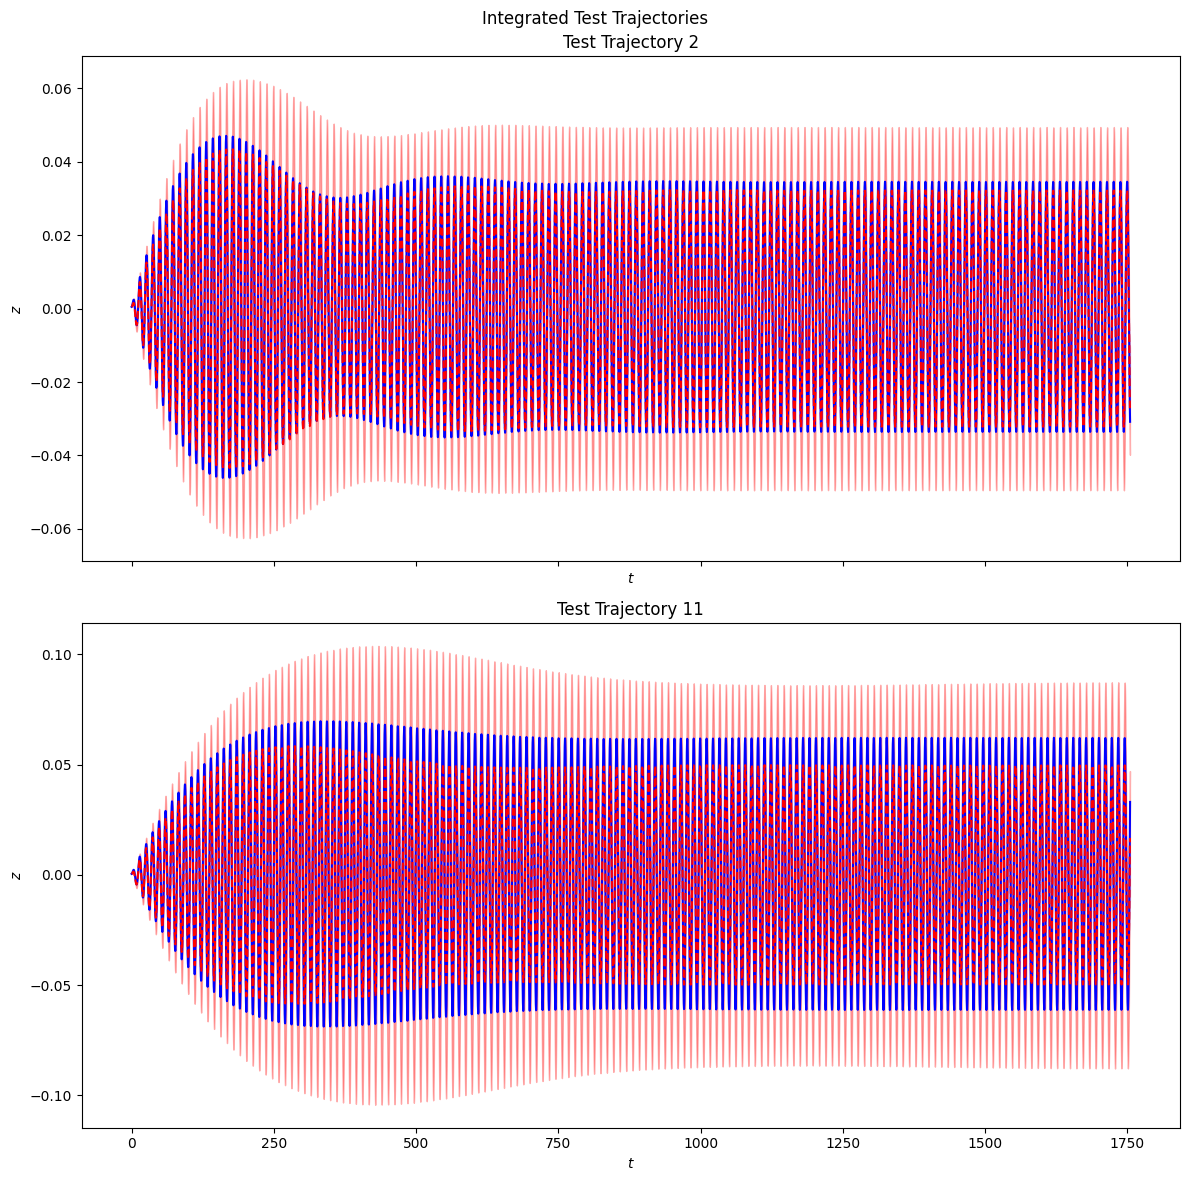

✓ UQ visualization completed

VENI-VINDy-VICI Analysis Complete!
   Total computation time: 87.8 minutes
   ✓ Governing equations discovered
   ✓ Predictions generated with uncertainty bounds
   ✓ MEMS beam dynamics successfully characterized


In [11]:
# Forward uncertainty quantification through ensemble sampling
print("Performing forward uncertainty quantification...")

N_SAMPLES = 10              # Number of uncertainty samples
print(f"   Uncertainty samples: {N_SAMPLES}")

uq_start = time.time()

try:
    # Generate uncertainty estimates through sampling
    uq_results = perform_forward_uq(
        veni,
        x_test_scaled,
        dxdt_test_scaled,
        dxddt_test_scaled,
        params_test,
        t_test,
        test_ids,
        N_SAMPLES,
        n_sims,
        n_timesteps_test,
        REDUCED_ORDER,
    )
    
    uq_time = time.time() - uq_start
    print(f"✓ Uncertainty quantification completed in {uq_time:.1f}s")
    
    # Analyze UQ results
    print(f"\nUQ Results Summary:")
    for i, test_id in enumerate(test_ids):
        mean_vals = uq_results["uq_ys_mean"][i]
        std_vals = uq_results["uq_ys_std"][i]
        
        avg_uncertainty = np.mean(std_vals)
        max_uncertainty = np.max(std_vals)
        
        print(f"   Trajectory {test_id}:")
        print(f"     Average uncertainty: {avg_uncertainty:.4f}")
        print(f"     Maximum uncertainty: {max_uncertainty:.4f}")
        
except Exception as e:
    print(f"Uncertainty quantification failed: {e}")
    raise

# Generate comprehensive visualization
print("\nGenerating uncertainty quantification plots...")
try:
    uq_plots(
        uq_results["uq_ts"],
        uq_results["uq_ys_mean"],
        uq_results["uq_ys_mean_sampled"],
        uq_results["uq_ys_std"],
        switch_data_format(t_test, n_sims, n_timesteps_test),
        uq_results["z_test"],
        test_ids,
    )
    print("✓ UQ visualization completed")
    
except Exception as e:
    print(f"Warning: Visualization failed: {e}")

print(f"\nVENI-VINDy-VICI Analysis Complete!")
print(f"   Total computation time: {(time.time() - training_start)/60:.1f} minutes")
print(f"   ✓ Governing equations discovered")
print(f"   ✓ Predictions generated with uncertainty bounds")
print(f"   ✓ MEMS beam dynamics successfully characterized")

## Analysis Summary & Insights

### Key Results

1. **Equation Discovery**: The framework successfully identified the governing equation for MEMS beam dynamics
2. **Uncertainty Quantification**: Provided credibility intervals for predictions through probabilistic modeling
3. **Dimensionality Reduction**: Reduced high-dimensional beam data to interpretable 1D latent dynamics

### Physical Interpretation

The discovered equation captures:
- **Natural Frequency**: $\omega_0$ in $-\omega_0^2 z$ 
- **Damping**: $-2\xi\omega_0\dot{z}$ 
- **Nonlinear effects**: $-\gamma z^3$ 
- **External forcing**: $u$

### Framework Advantages

- **Automated discovery**: No prior assumption about equation form
- **Uncertainty aware**: Quantifies confidence in identified terms
- **Scalable**: Handles high-dimensional spatial data
- **Physics-consistent**: Respects conservation laws and dynamics structure